# **Fraud Detection**

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from datetime import datetime as dt
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px
from matplotlib import cm

# Data Preprocessing
from sklearn.model_selection import train_test_split
from feature_engine.outliers import OutlierTrimmer, Winsorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder, OrdinalEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from mlxtend.plotting import plot_confusion_matrix

# Metric
from sklearn.metrics import classification_report, roc_auc_score, auc, RocCurveDisplay, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Deployment
import joblib
import pickle

# from packages.checker import check_unique
# from packages.checker import check_missing, check_missing_special
# from packages.outlier_handling import check_outlier, check_dist, outlier_summary, trim_cap_outliers

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('dataset_fraud_detection.csv')

In [3]:
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [4]:
# Duplicate Dataset
dataNew = data.copy()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


# **Exploratory Data Analysis**

**Comparison Type**

<AxesSubplot:xlabel='type', ylabel='count'>

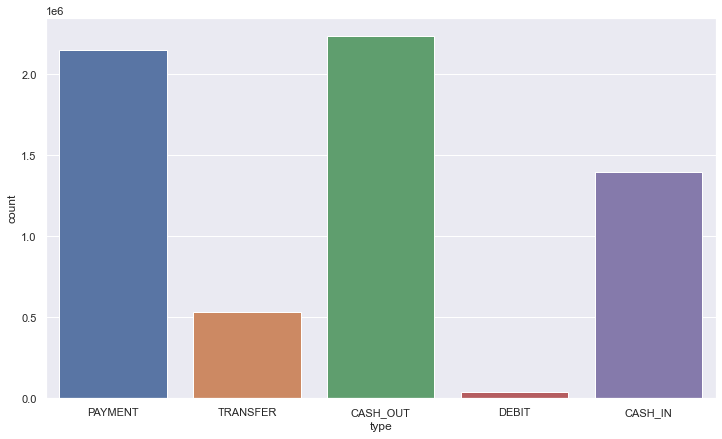

In [13]:
sns.set(rc={'figure.figsize':(12,7)})
sns.countplot(data=data, x='type')

**Amount Highest based on Type**

In [14]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [18]:
dataAmountType = data.groupby('type')[['amount']].mean().reset_index().sort_values('amount', ascending=True)
dataAmountType

,type,amount
2,DEBIT,5483.665314
3,PAYMENT,13057.604660
0,CASH_IN,168920.242004
1,CASH_OUT,176273.964346
4,TRANSFER,910647.009645


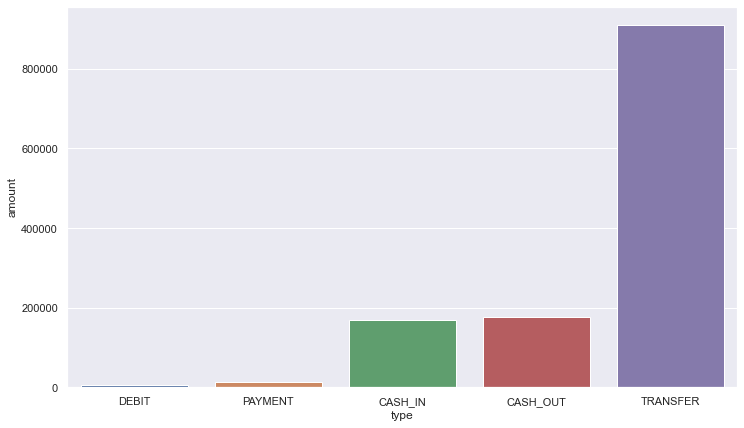

In [20]:
sns.set(rc={'figure.figsize':(12,7)})
sns.barplot(data=dataAmountType, x='type', y='amount')
plt.show()

## **Comparing Target Values dengan type**

In [23]:
# Create function for boxplot
def boxplot_variation(feature1, feature2, feature3, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width,6))
    s = sns.boxplot(ax = ax1, x=feature1, y=feature2, hue=feature3,
                data=data, palette="PRGn",showfliers=False)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()

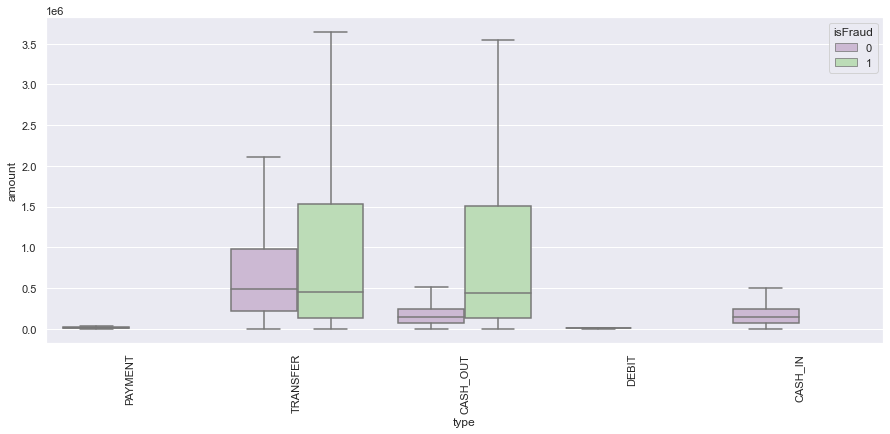

In [24]:
boxplot_variation('type','amount', 'isFraud',15)

## **Comparing Numerical Values**

In [35]:
data.tail(20)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362600,742,TRANSFER,652993.91,C40604503,652993.91,0.0,C1166857907,0.00,0.00,1,0
6362601,742,CASH_OUT,652993.91,C1614818636,652993.91,0.0,C362803701,0.00,652993.91,1,0
6362602,742,TRANSFER,1819543.69,C2089752665,1819543.69,0.0,C112833674,0.00,0.00,1,0
6362603,742,CASH_OUT,1819543.69,C1039979813,1819543.69,0.0,C2078394828,0.00,1819543.69,1,0
6362604,742,TRANSFER,54652.46,C1674778854,54652.46,0.0,C1930074465,0.00,0.00,1,0
6362605,742,CASH_OUT,54652.46,C43545501,54652.46,0.0,C830041824,0.00,54652.46,1,0
6362606,742,TRANSFER,303846.74,C959102961,303846.74,0.0,C114421319,0.00,0.00,1,0
6362607,742,CASH_OUT,303846.74,C1148860488,303846.74,0.0,C846260566,343660.89,647507.63,1,0
6362608,742,TRANSFER,258355.42,C1226129332,258355.42,0.0,C1744173808,0.00,0.00,1,0
6362609,742,CASH_OUT,258355.42,C1113162093,258355.42,0.0,C797688696,25176.67,283532.09,1,0


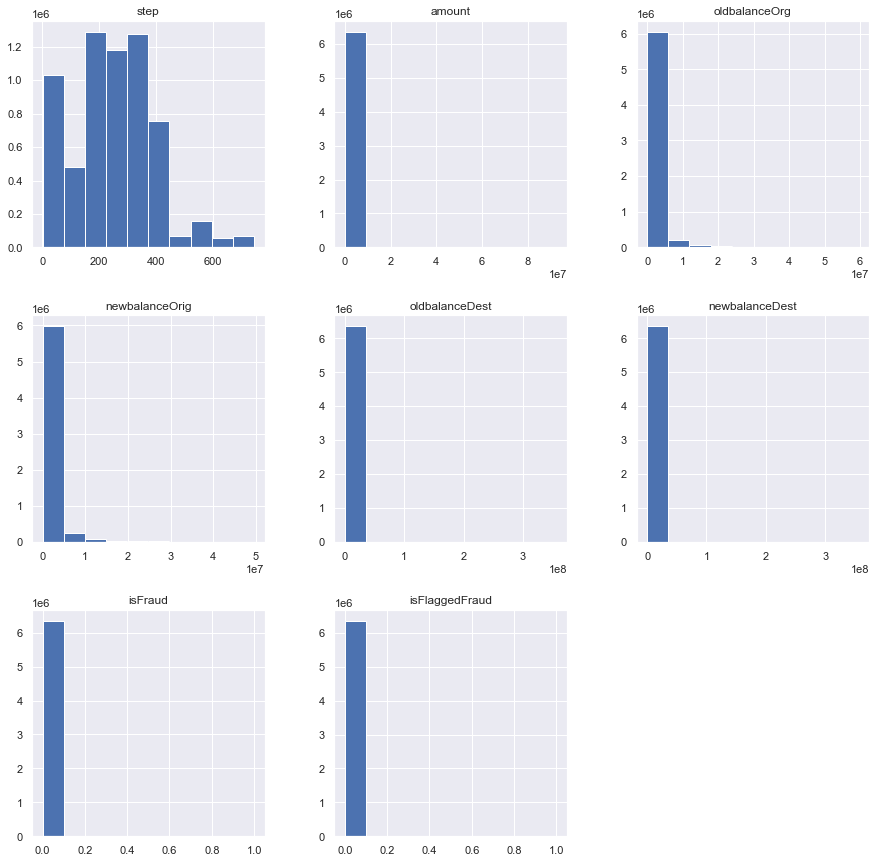

In [31]:
data.hist()
plt.gcf().set_size_inches(15, 15)
plt.show()

## **Heatmap**

### Checking correlation between each variables

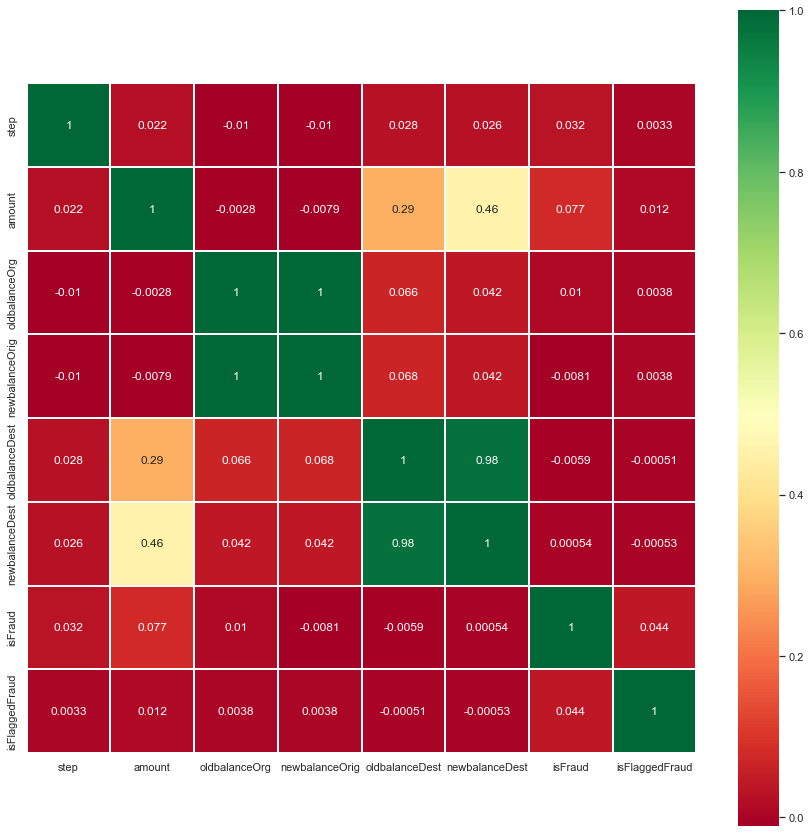

In [25]:
corrmat = data.corr()
top_corr_feature = corrmat.index

plt.figure(figsize=(15,15))

g = sns.heatmap(data[top_corr_feature].corr(), annot=True, cmap='RdYlGn', square=1, linewidths=0.05)

### Checking correlation between target variable and input variables

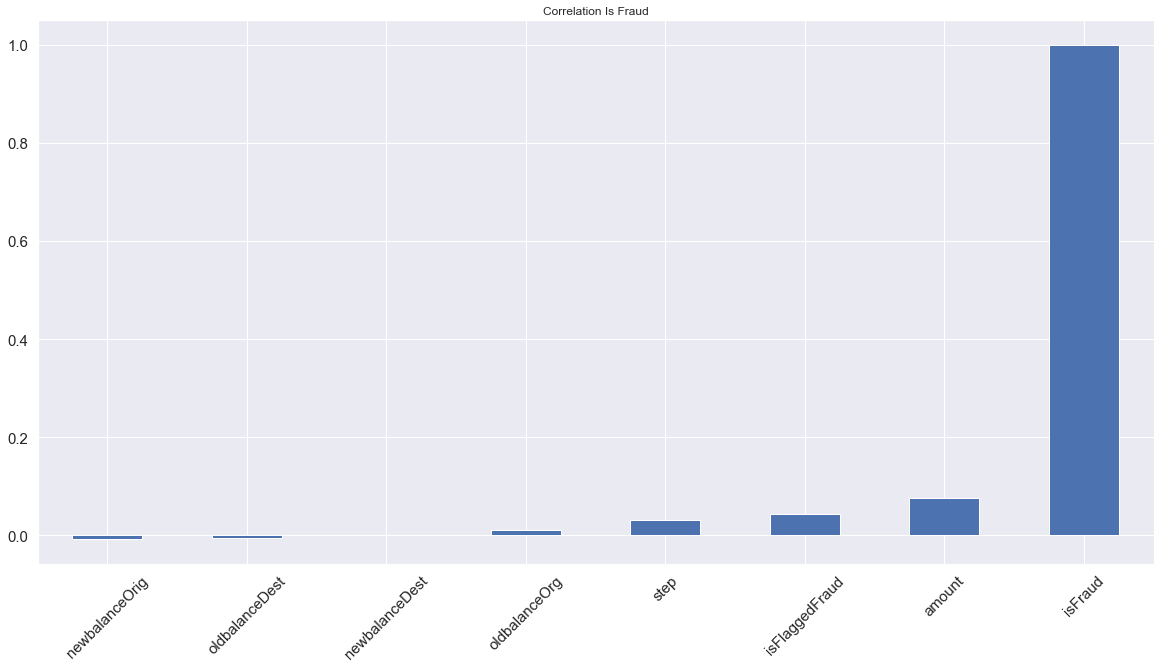

In [28]:
data.corrwith(data['isFraud']).sort_values().plot.bar(figsize=(20,10), title='Correlation Is Fraud', fontsize=15, rot=45, grid=True)
plt.show()

# **Data Preprocessing**